In [1]:
import casadi as ca
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
np.random.seed(3)

In [ ]:
colors = {
    "safe": "#2c7bb6",      # Dark Blue
    "low": "#abd9e9",       # Light Blue
    "very_low": "#fdae61",  # Orange
    "crash": "#d7191c"      # Red
}

# Physical constants
m = 4662
g = 32.172
delta = 0.03491
A0 = 0.4456e5
A1 = -0.2398e2
A2 = 0.1442e-1
rho = 0.2203e-2
S = 0.1560e4
beta0 = 0.4
beta_dot0 = 0.2
sigma = 3
B0 = 0.1552
B1 = 0.12369
B2 = 2.4203
C0 = 0.7125
C1 = 6.0877
C2 = -9.0277
alpha_star = 0.20944
a = 6e-8
b = -4e-11
c = -np.log(25/30.6)*1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
eps = 1e-6

wx1 = 500
wx2 = 4100
wx3 = 4600

wh1 = 500
wh2 = 4100
wh3 = 4600

# Wind model functions
def Smooth(x_, x0, x1):
    t = (x_ - x0) / (x1 - x0 + eps)
    return ca.if_else(x_ < x0, 0,
           ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

def A_piecewise(x_):
    A1v = -50 + a * x_**3 + b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
    A4 = 50
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*A1v + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4
    return ca.if_else(x_ <= wx1, B12,
           ca.if_else(x_ <= wx2, B23,
           ca.if_else(x_ <= wx3, B34, A4)))

def B_piecewise(x_):
    B1v = d * x_**3 + e * x_**4
    B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
    B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
    B4 = 0
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*B1v + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4
    return ca.if_else(x_ <= wh1, B12,
           ca.if_else(x_ <= wh2, B23,
           ca.if_else(x_ <= wh3, B34, B4)))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = ca.fmax(h_, 10.0)
    return k_ * h_safe / h_star * B_piecewise(x_)

def originalWindModel(x_, h_, k_):
    return wind_x(x_, k_), wind_h(x_, h_, k_)

def C_L(alpha_):
    return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                      C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
def beta(t_):
    return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

def aircraft_ode(k_value):
    x_ = ca.MX.sym('x')
    h_ = ca.MX.sym('h')
    V_ = ca.MX.sym('V')
    gamma_ = ca.MX.sym('gamma')
    alpha_ = ca.MX.sym('alpha')

    u_ = ca.MX.sym('u')
    t_ = ca.MX.sym('t')

    T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
    D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
    L = 0.5 * rho * S * C_L(alpha_) * V_**2

    Wx, Wh = originalWindModel(x_, h_, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_], [ca.gradient(Wx, x_)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_, h_], [ca.gradient(Wh, x_)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_, h_], [ca.gradient(Wh, h_)])

    V_safe = ca.fmax(V_, 1e-3)

    x_dot = V_ * ca.cos(gamma_) + Wx
    h_dot = V_ * ca.sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = (
        T / m * ca.cos(alpha_ + delta)
        - D / m
        - g * ca.sin(gamma_)
        - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
    )
    gamma_dot = (
        T / (m * V_safe) * ca.sin(alpha_ + delta)
        + L / (m * V_safe)
        - g / V_safe * ca.cos(gamma_)
        + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
    )
    alpha_dot = u_

    y0 = ca.vertcat(x_, h_, V_, gamma_, alpha_)
    yk = ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)
    return ca.Function('f', [y0, u_, t_], [yk])

def rk4_step(f, xk, uk, tk, dt):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def reconstruct_trajectory(u_opt, k, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=40, N=80):
    dt = tf / N
    traj = {"x": [], "h": [], "V": [], "gamma": [], "alpha": [], "t": []}
    X = np.array([x0, h0, V0, gamma0, alpha0])

    f = aircraft_ode(k)

    for i, u in enumerate(u_opt):
        t = i * dt
        traj["x"].append(float(X[0]))
        traj["h"].append(float(X[1]))
        traj["V"].append(float(X[2]))
        traj["gamma"].append(float(X[3]))
        traj["alpha"].append(float(X[4]))
        traj["t"].append(t)
        X = rk4_step(f, X, u, t, dt)

    traj["x"].append(float(X[0]))
    traj["h"].append(float(X[1]))
    traj["V"].append(float(X[2]))
    traj["gamma"].append(float(X[3]))
    traj["alpha"].append(float(X[4]))
    traj["t"].append(t + dt)
    return traj

def visualize_trajectory(u_opt, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=40, N=80):
    k_values = np.random.normal(1.0, 0.25, 10000)

    under_0, under_50, under_100 = 0, 0, 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for k in k_values:
        traj = reconstruct_trajectory(u_opt, k)

        if min(traj["h"]) < 1e-6:
            under_0 += 1
            print(k)
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["crash"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["crash"])
        elif min(traj["h"]) < 50:
            under_50 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["very_low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["very_low"])
        elif min(traj["h"]) < 100:
            under_100 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["low"])
        else:
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["safe"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["safe"])

    ax1.set_xlabel("x [ft]")
    ax1.set_ylabel("h [ft]")
    ax1.set_title("Trajectory (x vs h)")
    ax1.grid(True)
    legend_elements = [
        Line2D([0], [0], color=colors["safe"],      lw=2, label='Safe (h ≥ 100 ft)'),
        Line2D([0], [0], color=colors["low"],       lw=2, label='Low (50 ≤ h < 100 ft)'),
        Line2D([0], [0], color=colors["very_low"],  lw=2, label='Very low (0 ≤ h < 50 ft)'),
        Line2D([0], [0], color=colors["crash"],     lw=2, label='Crash (h ≤ 0)')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', title="Min Altitude Zones")

    ax2.set_xlabel("t [sec]")
    # ax2.set_xlabel("x [ft]")
    ax2.set_ylabel("V [ft/s]")
    ax2.set_title("Velocity (V vs t)")
    ax2.grid(True)
    # ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"P(Under 100) = {(under_100+under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 50) = {(under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 0) = {under_0/len(k_values):.4f}")

In [4]:
def plot_pce_trajectories(res, tf=40, N=80):
    x = res['x']    # shape: (M, N+1)
    h = res['h']
    V = res['V']
    M = x.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    print(min(h.flatten()))

    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(1,2,1)
    for j in range(M):
        plt.plot(x[j], h[j], label=f'PCE node {j+1}')
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()

    # V-t plot
    plt.subplot(1,2,2)
    for j in range(M):
        plt.plot(t_grid, V[j], label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
def solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25):
    # Time and discretization
    tf = 40        # final time [sec]
    N = 80         # number of control intervals
    dt = tf / N    # time step

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    nodes = nodes.flatten()
    M = len(nodes)    # M = pce_order + 1

    Psi_mat = np.zeros((M, M))
    for i in range(M):
        Psi_mat[:, i] = poly_basis[i](nodes)

    Psi_dm = ca.DM(Psi_mat)
    weights_dm = ca.DM(weights).T

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    X_pce = opti.variable(5*(pce_order+1), N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    def wind_x(x_, k_):
        return k_ * A_piecewise(x_)

    def wind_h(x_, h_, k_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    k_sym = ca.MX.sym("k")
    Wx_expr = wind_x(x_sym, k_sym)
    Wh_expr = wind_h(x_sym, h_sym, k_sym)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_, k_val):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2

        Wx = wind_x(x_, k_val)
        Wh = wind_h(x_, h_, k_val)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_, k_val)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_, k_val)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_, k_val)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt, k_val):
        k1 = f(xk, uk, tk, k_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # # Integration using RK4
    # X_sym = ca.MX.sym("X", 5)
    # u_sym = ca.MX.sym("u")

    J = 0

    # Initial conditions
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
    opti.subject_to(gamma_s[:, -1] >= 0)

    # for i in range(N):
    #     h_physical = h_s[:, i] * hscale
    #     h_mean = ca.mtimes(weights_dm, h_physical)
    #     deviation = hR - h_mean
    #     scaled_deviation = deviation / hscale
    #     J += dt * scaled_deviation**6

    #     for j, k_val in enumerate(nodes):
    #         tk = i * dt     # New line
    #         Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
    #         Uk = u[i]
    #         Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
    #         X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
    #         opti.subject_to(X_next == Xk_end)

    #     opti.subject_to(opti.bounded(-1, u_s[i], 1))
    #     alpha_i = alpha_s[:, i] * alphascale
    #     alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
    #     alpha_high_coeffs = alpha_pce_coeffs[1:]
    #     alpha_mean = ca.mtimes(weights_dm, alpha_i)
    #     std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

    #     opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
    #     opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)

    for j, k_val in enumerate(nodes):

        for i in range(N):
            h_physical = h_s[:, i] * hscale
            h_mean = ca.mtimes(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(weights_dm * h_physical.T, Psi_dm)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            tk = i * dt     # New line
            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.mtimes(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

        opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
        opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)


    # # Cost function
    # J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opts = {
        "expand": True,
        "ipopt": {
            # "max_iter": 3000,
            "max_cpu_time": 120,
            "tol": 1e-6,
            "print_level": 0,
            "linear_solver": "mumps",
            "hessian_approximation": "limited-memory",
            # "bound_push": 1e-8,
            # "bound_frac": 1e-8
        }
    }
    opti.solver("ipopt", opts)

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        print(e)
        return {
            "x": opti.debug.value(x),
            "h": opti.debug.value(h),
            "V": opti.debug.value(V),
            "gamma": opti.debug.value(gamma),
            "alpha": opti.debug.value(alpha),
            "u": opti.debug.value(u),
            "J": opti.debug.value(J),
            "status": "failed"
        }

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
        "status": "success"
    }

## Compare Different Order of PCE

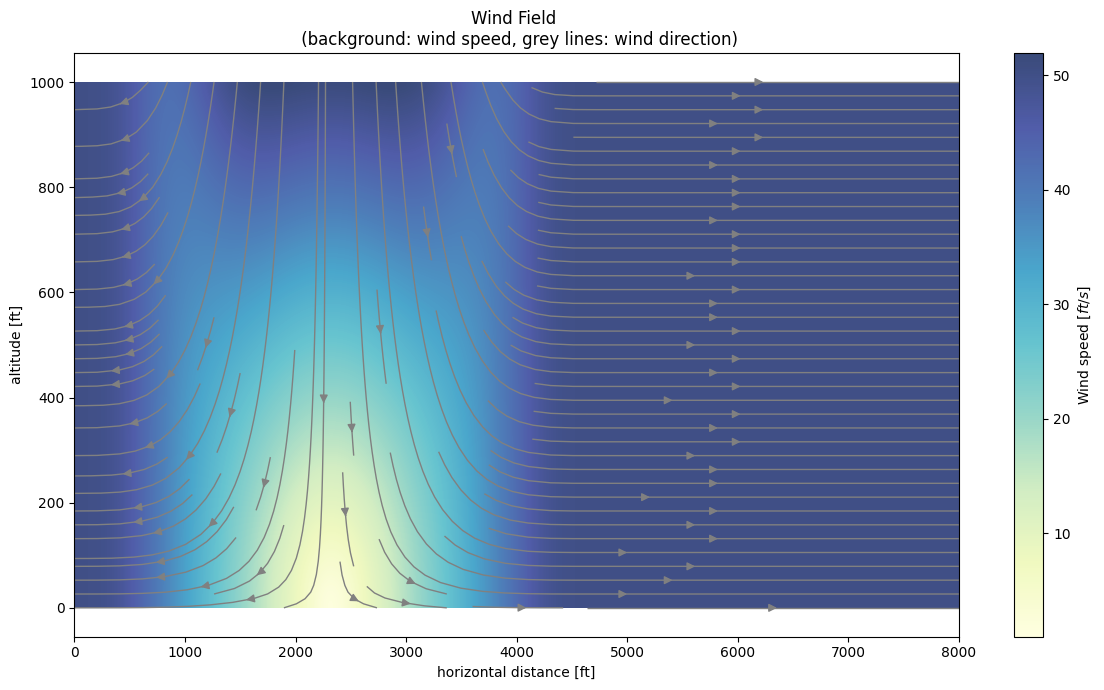

In [6]:
# --------- Wind Field ---------
k_value = 1   # wind intensity factor
x_range = np.linspace(0, 8000, 61)
h_range = np.linspace(0, 1000, 61)
X, H = np.meshgrid(x_range, h_range)

Wx = wind_x(X, k_value)
Wh = wind_h(X, H, k_value)
wind_strength = np.sqrt(Wx**2 + Wh**2)

# --------- Background ---------
plt.figure(figsize=(12, 7))
im = plt.imshow(wind_strength, extent=(x_range[0], x_range[-1], h_range[0], h_range[-1]),
                origin='lower', aspect='auto', cmap='YlGnBu', interpolation='bicubic', alpha=0.8)

plt.colorbar(im, label='Wind speed $[ft/s]$')

# --------- Wind Direction Streamlines ---------
plt.streamplot(x_range, h_range, Wx, Wh, color='grey', linewidth=1, density=1.3, arrowsize=1.2, arrowstyle='-|>')


plt.xlabel('horizontal distance [ft]')
plt.ylabel('altitude [ft]')
plt.title(f'Wind Field \n (background: wind speed, grey lines: wind direction)')
# plt.legend()
plt.tight_layout()
plt.show()

### Order 2

In [7]:
res2 = solve_ocp_pce(pce_order=2, k_mean=1.0, k_std=0.25)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.01ms ( 27.92us)   2.01ms ( 27.92us)        72
       nlp_g  | 128.22ms (  1.78ms) 130.43ms (  1.81ms)        72
  nlp_grad_f  |   2.80ms ( 43.08us)   2.79ms ( 42.98us)        65
   nlp_jac_g  | 683.41ms ( 10.51ms) 690.86ms ( 10.63ms)        65
       total  |   1.59 s (  1.59 s)   1.63 s (  1.63 s)         1


135.7377697229124


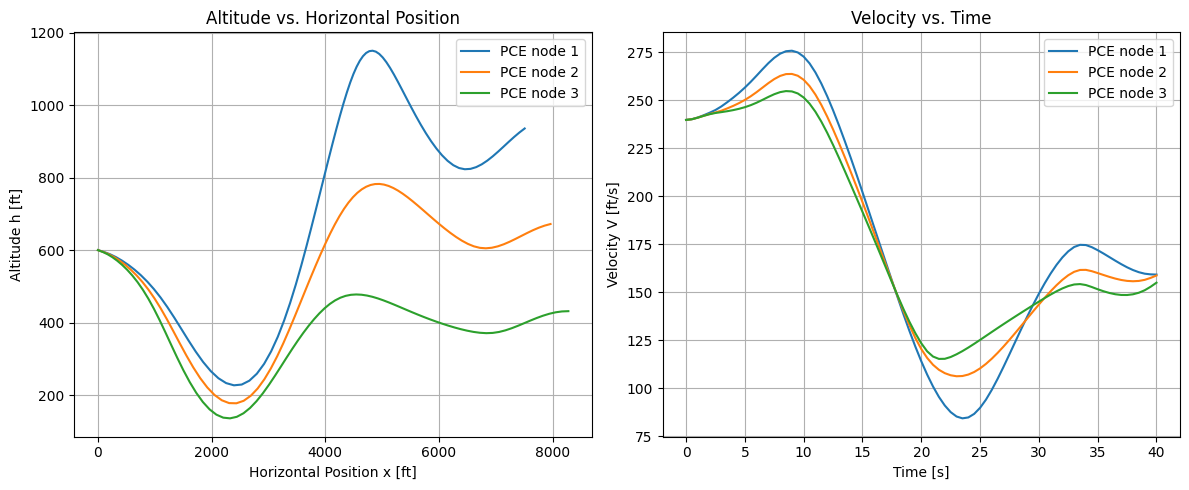

In [8]:
plot_pce_trajectories(res2)

2.0228481898934128


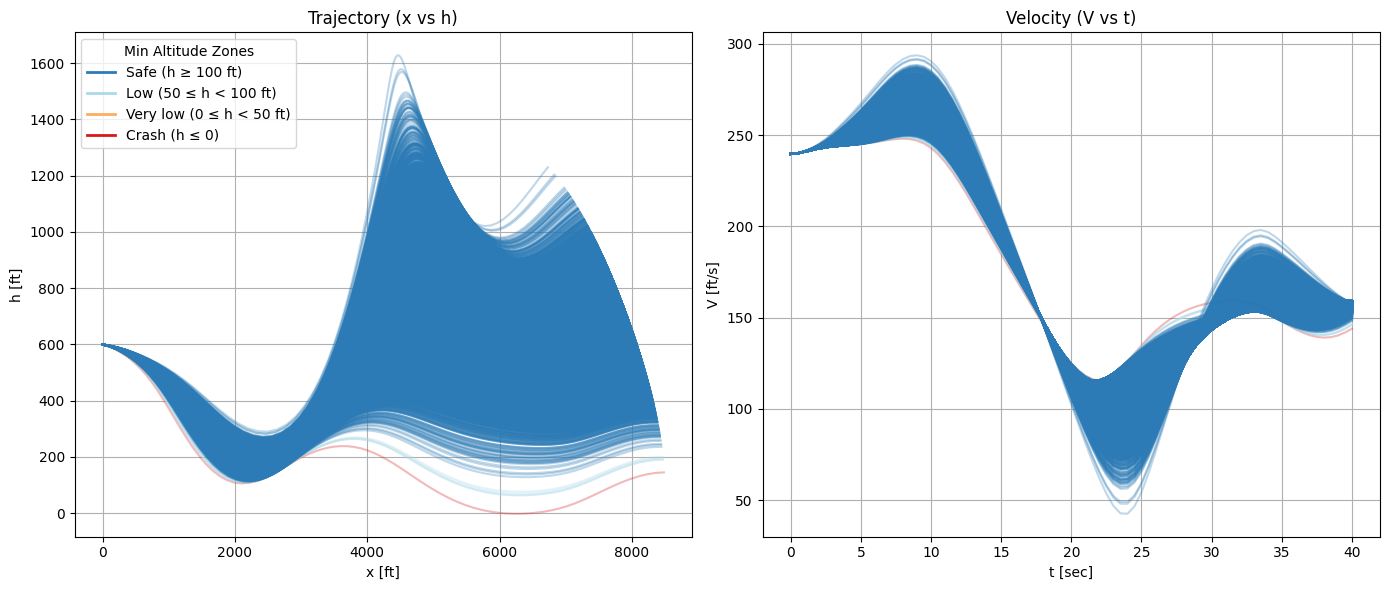

P(Under 100) = 0.0005
P(Under 50) = 0.0001
P(Under 0) = 0.0001


In [ ]:
visualize_trajectory(res2["u"])

### Order 3

In [10]:
res3 = solve_ocp_pce(pce_order=3, k_mean=1.0, k_std=0.25)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.91ms ( 37.74us)   2.91ms ( 37.84us)        77
       nlp_g  | 176.93ms (  2.30ms) 177.04ms (  2.30ms)        77
  nlp_grad_f  |   5.09ms ( 68.74us)   5.08ms ( 68.59us)        74
   nlp_jac_g  |   1.01 s ( 13.62ms)   1.01 s ( 13.63ms)        74
       total  |   2.23 s (  2.23 s)   2.23 s (  2.23 s)         1


124.62224973365379


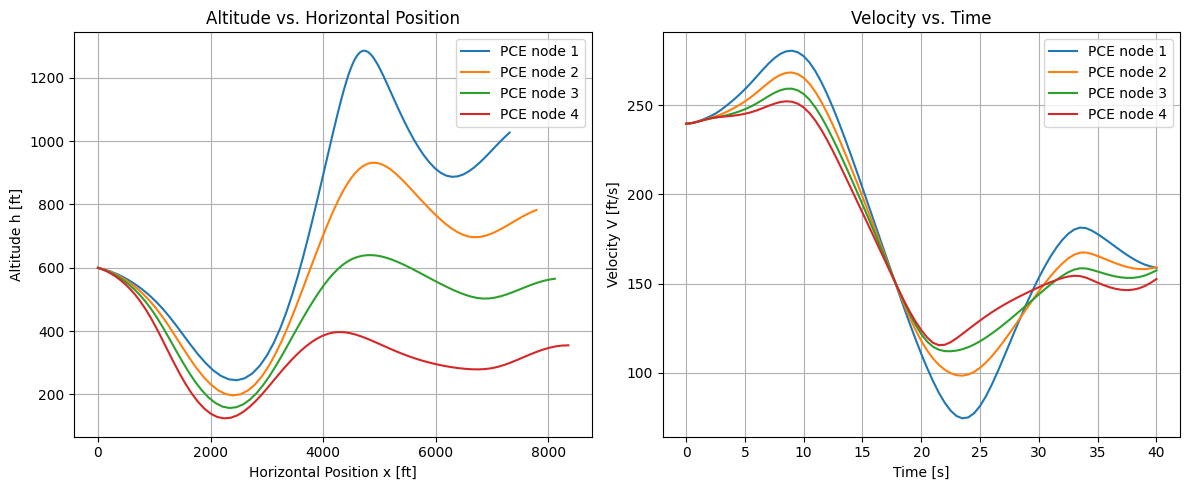

In [11]:
plot_pce_trajectories(res3)

2.091732386036801


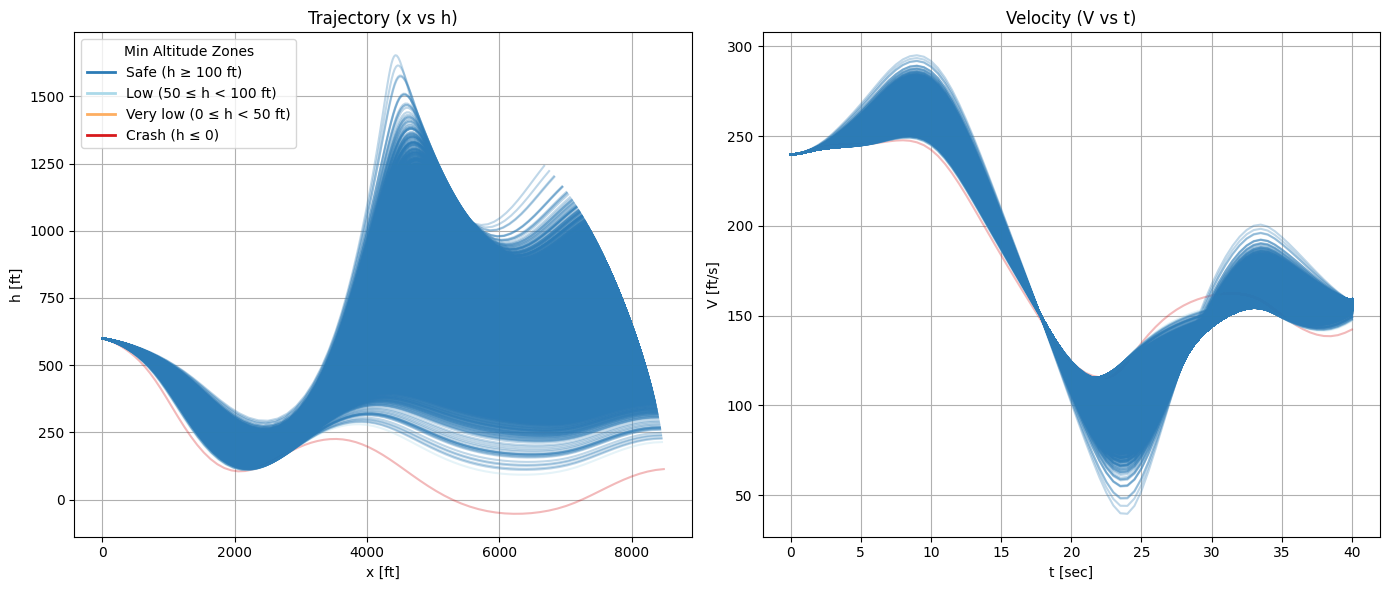

P(Under 100) = 0.0002
P(Under 50) = 0.0001
P(Under 0) = 0.0001


In [ ]:
visualize_trajectory(res3["u"])

### Order 5

In [13]:
res5 = solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   6.56ms ( 88.65us)   6.56ms ( 88.60us)        74
       nlp_g  | 254.97ms (  3.45ms) 255.10ms (  3.45ms)        74
  nlp_grad_f  |  11.13ms (161.26us)  11.13ms (161.33us)        69
   nlp_jac_g  |   1.40 s ( 20.33ms)   1.40 s ( 20.34ms)        69
       total  |   3.11 s (  3.11 s)   3.11 s (  3.11 s)         1


110.66784346595338


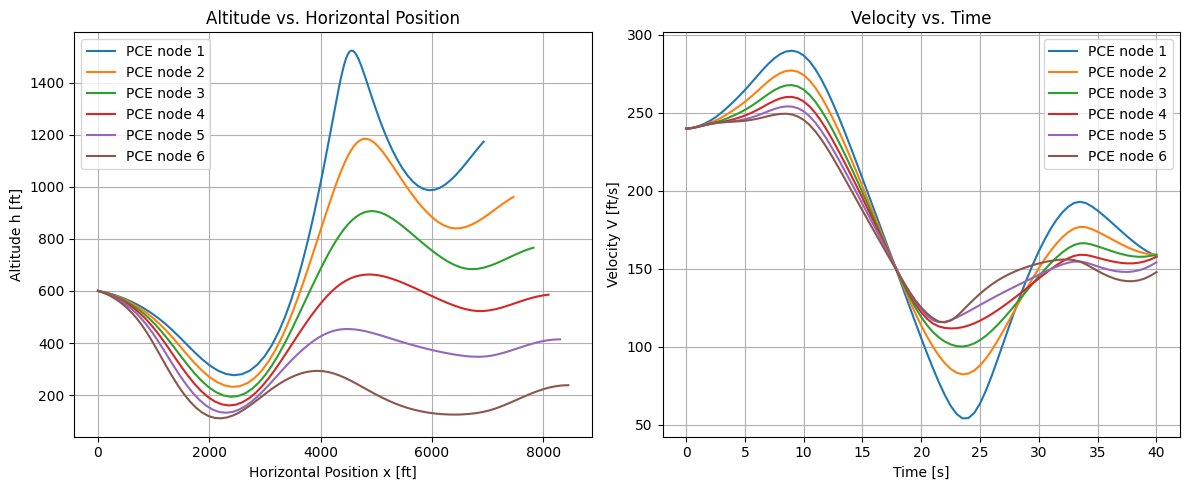

In [14]:
plot_pce_trajectories(res5)

2.0323963311238638
1.9578456378697613


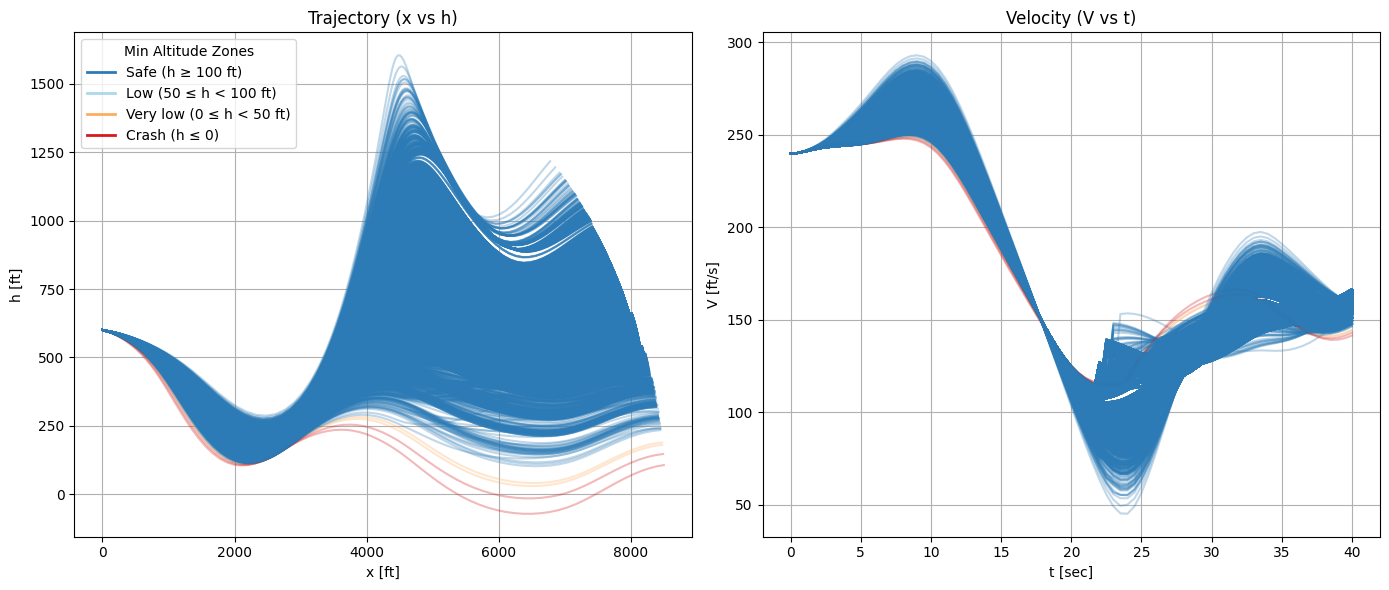

P(Under 100) = 0.0004
P(Under 50) = 0.0004
P(Under 0) = 0.0002


In [58]:
visualize_trajectory(res5["u"])

## Wider Wind 1.1

Wind width scaled by factor 1.1

In [59]:
colors = {
    "safe": "#2c7bb6",      # Dark Blue
    "low": "#abd9e9",       # Light Blue
    "very_low": "#fdae61",  # Orange
    "crash": "#d7191c"      # Red
}

# Physical constants
m = 4662
g = 32.172
delta = 0.03491
A0 = 0.4456e5
A1 = -0.2398e2
A2 = 0.1442e-1
rho = 0.2203e-2
S = 0.1560e4
beta0 = 0.4
beta_dot0 = 0.2
sigma = 3
B0 = 0.1552
B1 = 0.12369
B2 = 2.4203
C0 = 0.7125
C1 = 6.0877
C2 = -9.0277
alpha_star = 0.20944
a = 6e-8
b = -4e-11
c = -np.log(25/30.6)*1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
eps = 1e-6

wx1 = 500
wx2 = 4100 * 1.1
wx3 = 4600 * 1.1

wh1 = 500
wh2 = 4100 * 1.1
wh3 = 4600 * 1.1

# Wind model functions
def Smooth(x_, x0, x1):
    t = (x_ - x0) / (x1 - x0 + eps)
    return ca.if_else(x_ < x0, 0,
           ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

def A_piecewise(x_):
    A1v = -50 + a * x_**3 + b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - a * (wx3 - x_)**3 - b * (wx3 - x_)**4
    A4 = 50
    s1 = Smooth(x_, wx1-30, wx2+30)
    s2 = Smooth(x_, wx2-30, wx2+30)
    s3 = Smooth(x_, wx3-30, wx3+30)
    B12 = (1 - s1)*A1v + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4
    # return ca.if_else(x_ <= wx1, B12,
    #        ca.if_else(x_ <= wx2, B23,
    #        ca.if_else(x_ <= wx3, B34, A4)))
    return ca.if_else(x_ <= wx1, B12,
           ca.if_else(x_ <= wx2, B23, A4))

def B_piecewise(x_):
    B1v = d * x_**3 + e * x_**4
    B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
    B3 = d * (wh3 - x_)**3 + e * (wh3 - x_)**4
    B4 = 0
    s1 = Smooth(x_, wh1-30, wh1+30)
    s2 = Smooth(x_, wh2-30, wh2+30)
    s3 = Smooth(x_, wh3-30, wh3+30)
    B12 = (1 - s1)*B1v + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4
    # return ca.if_else(x_ <= wh1, B12,
    #        ca.if_else(x_ <= wh2, B23,
    #        ca.if_else(x_ <= wh3, B34, B4)))
    return ca.if_else(x_ <= wh1, B12,
           ca.if_else(x_ <= wh2, B23, B4))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = ca.fmax(h_, 10.0)
    return k_ * h_safe / h_star * B_piecewise(x_)

def originalWindModel(x_, h_, k_):
    return wind_x(x_, k_), wind_h(x_, h_, k_)

def C_L(alpha_):
    return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                      C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
def beta(t_):
    return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

def aircraft_ode(k_value):
    x_ = ca.MX.sym('x')
    h_ = ca.MX.sym('h')
    V_ = ca.MX.sym('V')
    gamma_ = ca.MX.sym('gamma')
    alpha_ = ca.MX.sym('alpha')

    u_ = ca.MX.sym('u')
    t_ = ca.MX.sym('t')

    T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
    D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
    L = 0.5 * rho * S * C_L(alpha_) * V_**2

    Wx, Wh = originalWindModel(x_, h_, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_], [ca.gradient(Wx, x_)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_, h_], [ca.gradient(Wh, x_)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_, h_], [ca.gradient(Wh, h_)])

    V_safe = ca.fmax(V_, 1e-3)

    x_dot = V_ * ca.cos(gamma_) + Wx
    h_dot = V_ * ca.sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = (
        T / m * ca.cos(alpha_ + delta)
        - D / m
        - g * ca.sin(gamma_)
        - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
    )
    gamma_dot = (
        T / (m * V_safe) * ca.sin(alpha_ + delta)
        + L / (m * V_safe)
        - g / V_safe * ca.cos(gamma_)
        + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
    )
    alpha_dot = u_

    y0 = ca.vertcat(x_, h_, V_, gamma_, alpha_)
    yk = ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)
    return ca.Function('f', [y0, u_, t_], [yk])

def rk4_step(f, xk, uk, tk, dt):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def reconstruct_trajectory(u_opt, k, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=50, N=100):
    dt = tf / N
    traj = {"x": [], "h": [], "V": [], "gamma": [], "alpha": [], "t": []}
    X = np.array([x0, h0, V0, gamma0, alpha0])

    f = aircraft_ode(k)

    for i, u in enumerate(u_opt):
        t = i * dt
        traj["x"].append(float(X[0]))
        traj["h"].append(float(X[1]))
        traj["V"].append(float(X[2]))
        traj["gamma"].append(float(X[3]))
        traj["alpha"].append(float(X[4]))
        traj["t"].append(t)
        X = rk4_step(f, X, u, t, dt)

    traj["x"].append(float(X[0]))
    traj["h"].append(float(X[1]))
    traj["V"].append(float(X[2]))
    traj["gamma"].append(float(X[3]))
    traj["alpha"].append(float(X[4]))
    traj["t"].append(t + dt)
    return traj

def visualize_trajectory(u_opt, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=40, N=80):
    k_values = np.random.normal(1.0, 0.25, 10000)

    under_0, under_50, under_100 = 0, 0, 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for k in k_values:
        traj = reconstruct_trajectory(u_opt, k)

        if min(traj["h"]) < 1e-6:
            under_0 += 1
            print(k)
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["crash"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["crash"])
        elif min(traj["h"]) < 50:
            under_50 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["very_low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["very_low"])
        elif min(traj["h"]) < 100:
            under_100 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["low"])
        else:
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["safe"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["safe"])

    ax1.set_xlabel("x [ft]")
    ax1.set_ylabel("h [ft]")
    ax1.set_title("Trajectory (x vs h)")
    ax1.grid(True)
    legend_elements = [
        Line2D([0], [0], color=colors["safe"],      lw=2, label='Safe (h ≥ 100 ft)'),
        Line2D([0], [0], color=colors["low"],       lw=2, label='Low (50 ≤ h < 100 ft)'),
        Line2D([0], [0], color=colors["very_low"],  lw=2, label='Very low (0 ≤ h < 50 ft)'),
        Line2D([0], [0], color=colors["crash"],     lw=2, label='Crash (h ≤ 0)')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', title="Min Altitude Zones")

    ax2.set_xlabel("t [sec]")
    # ax2.set_xlabel("x [ft]")
    ax2.set_ylabel("V [ft/s]")
    ax2.set_title("Velocity (V vs t)")
    ax2.grid(True)
    # ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"P(Under 100) = {(under_100+under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 50) = {(under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 0) = {under_0/len(k_values):.4f}")

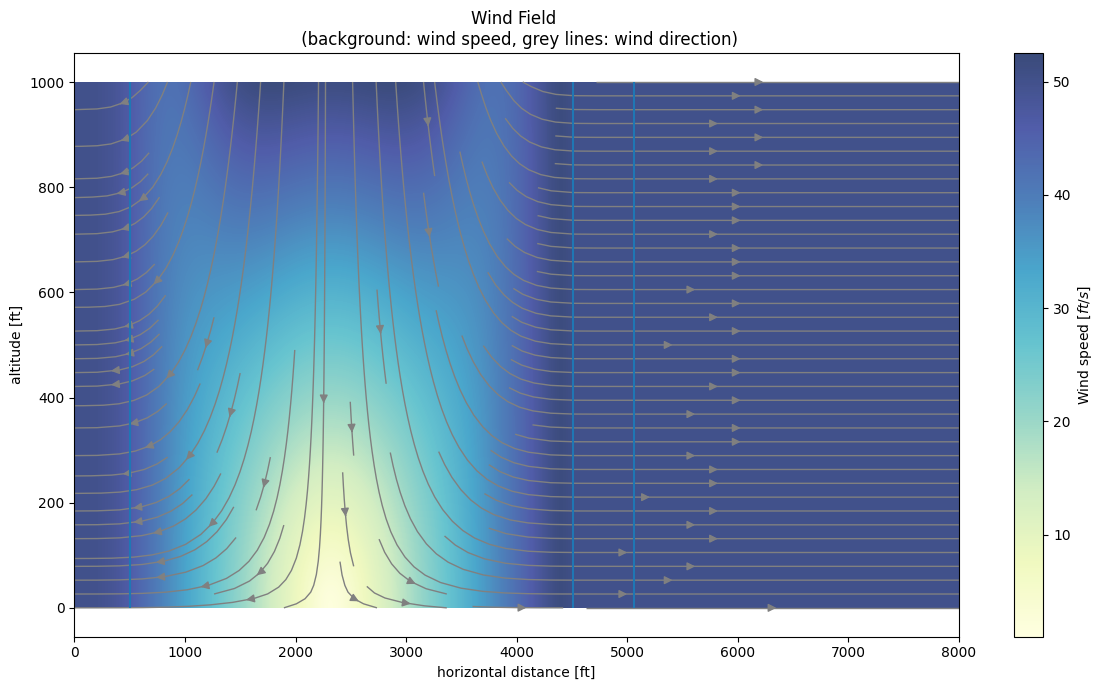

In [60]:
# --------- Wind Field ---------
k_value = 1   # wind intensity factor
x_range = np.linspace(0, 8000, 61)
h_range = np.linspace(0, 1000, 61)
X, H = np.meshgrid(x_range, h_range)

Wx = wind_x(X, k_value)
Wh = wind_h(X, H, k_value)
wind_strength = np.sqrt(Wx**2 + Wh**2)

# --------- Background ---------
plt.figure(figsize=(12, 7))
im = plt.imshow(wind_strength, extent=(x_range[0], x_range[-1], h_range[0], h_range[-1]),
                origin='lower', aspect='auto', cmap='YlGnBu', interpolation='bicubic', alpha=0.8)

plt.colorbar(im, label='Wind speed $[ft/s]$')

# --------- Wind Direction Streamlines ---------
plt.streamplot(x_range, h_range, Wx, Wh, color='grey', linewidth=1, density=1.3, arrowsize=1.2, arrowstyle='-|>')

plt.vlines(wx1, 0, 1000)
plt.vlines(wx2, 0, 1000)
plt.vlines(wx3, 0, 1000)


plt.xlabel('horizontal distance [ft]')
plt.ylabel('altitude [ft]')
plt.title(f'Wind Field \n (background: wind speed, grey lines: wind direction)')
# plt.legend()
plt.tight_layout()
plt.show()

In [61]:
def plot_pce_trajectories(res, tf=50, N=100):
    x = res['x']    # shape: (M, N+1)
    h = res['h']
    V = res['V']
    M = x.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    print(min(h.flatten()))

    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(1,2,1)
    for j in range(M):
        plt.plot(x[j], h[j], label=f'PCE node {j+1}')
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()
    x_range = np.linspace(0, 12000, 61)
    h_range = np.linspace(0, 1000, 61)
    plt.streamplot(x_range, h_range, Wx, Wh, color='grey', linewidth=1, density=1.3, arrowsize=1.2, arrowstyle='-|>')

    # V-t plot
    plt.subplot(1,2,2)
    for j in range(M):
        plt.plot(t_grid, V[j], label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [62]:
def solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25):
    # Time and discretization
    tf = 50        # final time [sec]
    N = 100        # number of control intervals
    dt = tf / N    # time step

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    nodes = nodes.flatten()
    M = len(nodes)    # M = pce_order + 1

    Psi_mat = np.zeros((M, M))
    for i in range(M):
        Psi_mat[:, i] = poly_basis[i](nodes)

    Psi_dm = ca.DM(Psi_mat)
    weights_dm = ca.DM(weights).T

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    X_pce = opti.variable(5*(pce_order+1), N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    k_sym = ca.MX.sym("k")
    Wx_expr = wind_x(x_sym, k_sym)
    Wh_expr = wind_h(x_sym, h_sym, k_sym)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_, k_val):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2

        Wx = wind_x(x_, k_val)
        Wh = wind_h(x_, h_, k_val)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_, k_val)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_, k_val)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_, k_val)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt, k_val):
        k1 = f(xk, uk, tk, k_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    J = 0

    # Initial conditions
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
    opti.subject_to(gamma_s[:, -1] >= 0)

    for j, k_val in enumerate(nodes):

        for i in range(N):
            h_physical = h_s[:, i] * hscale
            h_mean = ca.mtimes(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(weights_dm * h_physical.T, Psi_dm)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            tk = i * dt     # New line
            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.mtimes(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

        opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
        opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)


    # # Cost function
    # J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opts = {
        "expand": True,
        "ipopt": {
            # "max_iter": 3000,
            "max_cpu_time": 120,
            "tol": 1e-6,
            "print_level": 0,
            "linear_solver": "mumps",
            "hessian_approximation": "limited-memory",
            # "bound_push": 1e-8,
            # "bound_frac": 1e-8
        }
    }
    opti.solver("ipopt", opts)

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        print(e)
        return {
            "x": opti.debug.value(x),
            "h": opti.debug.value(h),
            "V": opti.debug.value(V),
            "gamma": opti.debug.value(gamma),
            "alpha": opti.debug.value(alpha),
            "u": opti.debug.value(u),
            "J": opti.debug.value(J),
            "status": "failed"
        }

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
        "status": "success"
    }

### Order 1

In [63]:
res_w_1 = solve_ocp_pce(pce_order=1)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  18.73ms ( 10.65us)  18.72ms ( 10.64us)      1759
       nlp_g  |   1.97 s (  1.12ms)   1.98 s (  1.13ms)      1759
  nlp_grad_f  |  14.77ms ( 19.49us)  14.70ms ( 19.39us)       758
   nlp_jac_g  |   5.18 s (  6.83ms)   5.25 s (  6.92ms)       758
       total  |  14.63 s ( 14.63 s)  14.82 s ( 14.82 s)         1


122.81813675876695


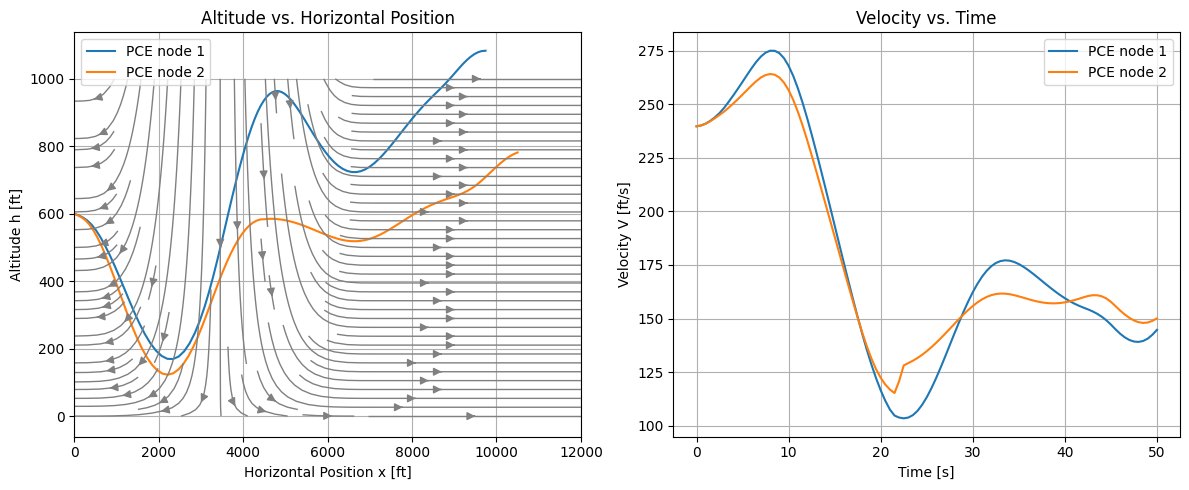

In [64]:
plot_pce_trajectories(res_w_1)

### Order 2

In [65]:
res_w_2 = solve_ocp_pce(pce_order=2)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  12.95ms ( 33.72us)  12.95ms ( 33.72us)       384
       nlp_g  | 647.59ms (  1.69ms) 653.95ms (  1.70ms)       384
  nlp_grad_f  |  13.91ms ( 52.11us)  13.90ms ( 52.05us)       267
   nlp_jac_g  |   2.75 s ( 10.30ms)   2.76 s ( 10.33ms)       267
       total  |   7.62 s (  7.62 s)   7.69 s (  7.69 s)         1


122.57159396077353


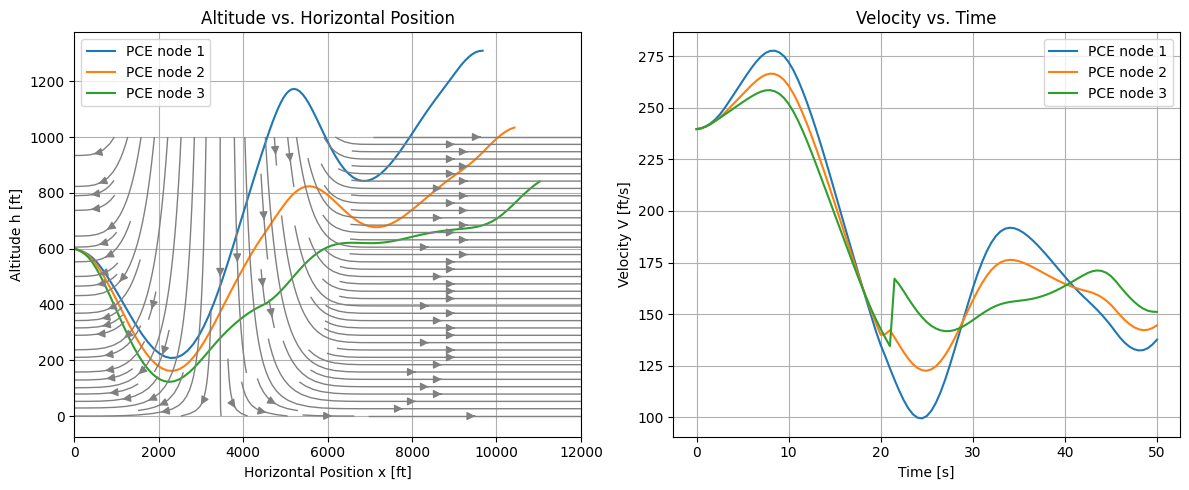

In [66]:
plot_pce_trajectories(res_w_2)

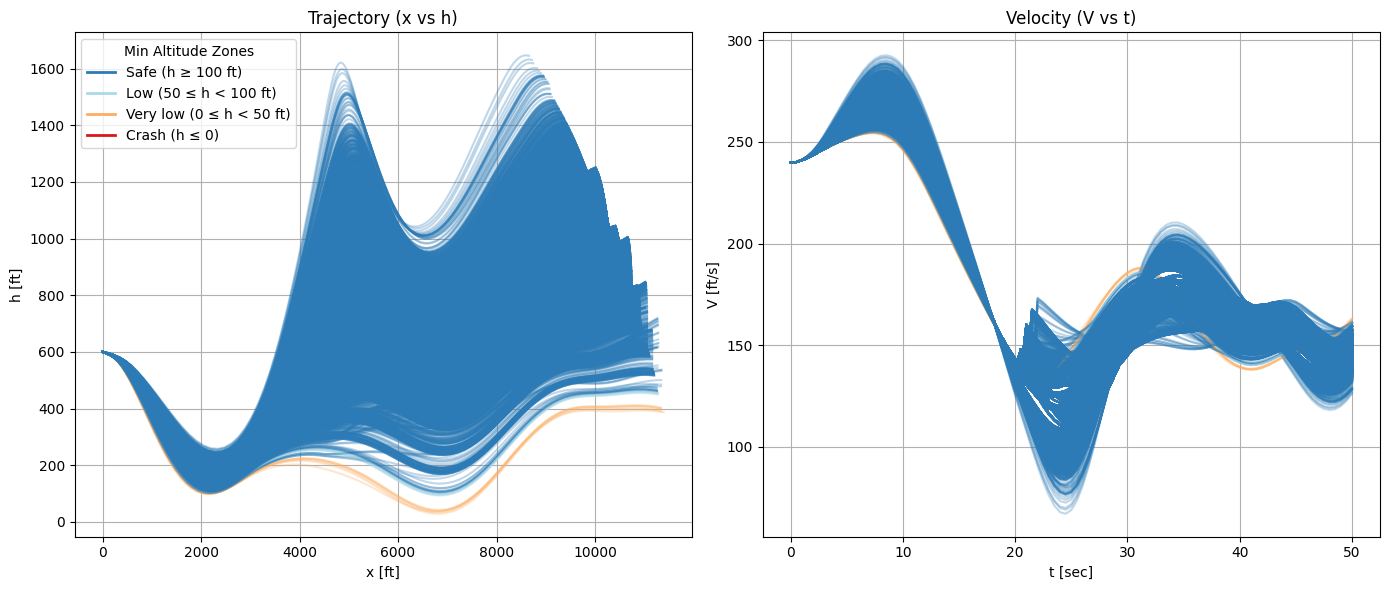

P(Under 100) = 0.0013
P(Under 50) = 0.0006
P(Under 0) = 0.0000


In [67]:
visualize_trajectory(res_w_2["u"])

### Order 3

In [68]:
res_w_3 = solve_ocp_pce(pce_order=3)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   6.82ms ( 44.90us)   6.84ms ( 45.00us)       152
       nlp_g  | 336.66ms (  2.21ms) 337.18ms (  2.22ms)       152
  nlp_grad_f  |  10.44ms ( 84.18us)  10.39ms ( 83.80us)       124
   nlp_jac_g  |   1.68 s ( 13.55ms)   1.68 s ( 13.58ms)       124
       total  |   4.40 s (  4.40 s)   4.41 s (  4.41 s)         1


87.54034293011735


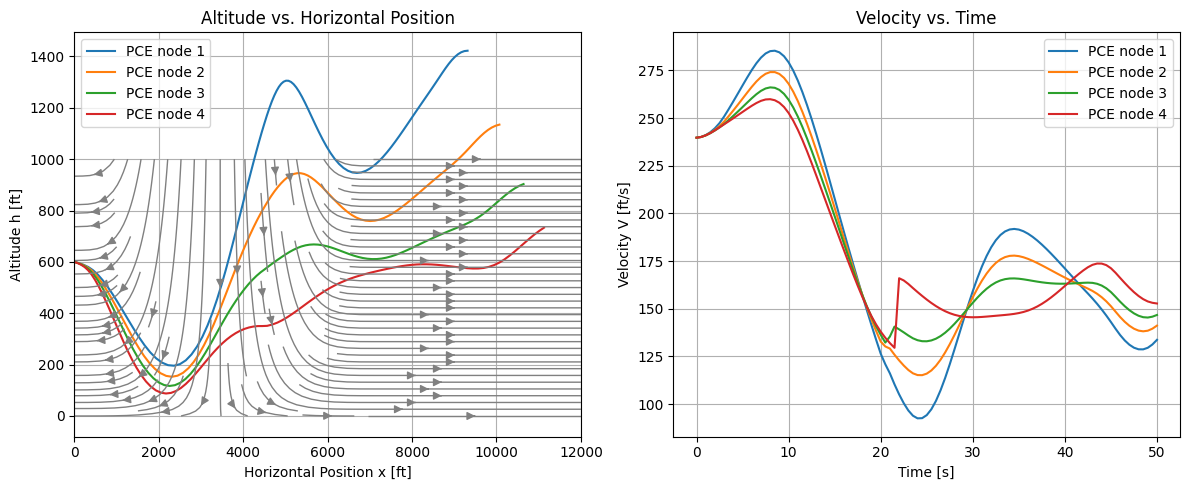

In [69]:
plot_pce_trajectories(res_w_3)

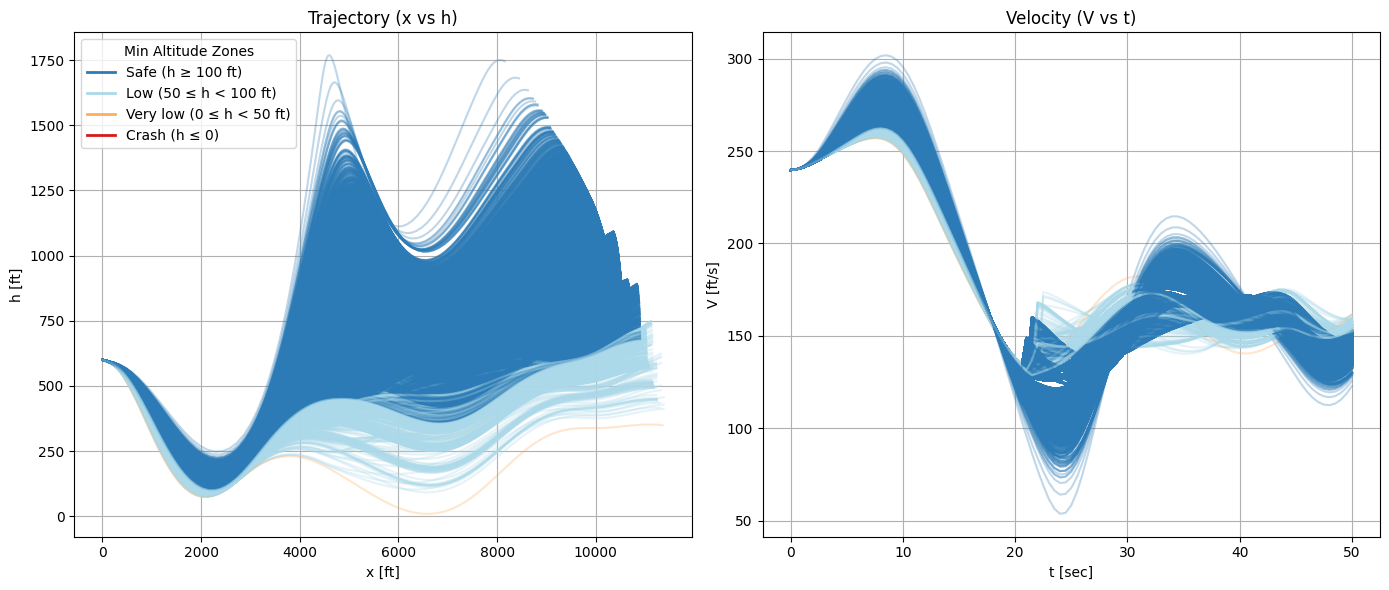

P(Under 100) = 0.0516
P(Under 50) = 0.0001
P(Under 0) = 0.0000


In [70]:
visualize_trajectory(res_w_3["u"])

### Order 5

In [71]:
res_w_5 = solve_ocp_pce(pce_order=5)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  32.40ms (104.86us)  32.43ms (104.95us)       309
       nlp_g  |   1.03 s (  3.33ms)   1.03 s (  3.33ms)       309
  nlp_grad_f  |  33.95ms (198.51us)  33.97ms (198.68us)       171
   nlp_jac_g  |   4.04 s ( 20.32ms)   4.05 s ( 20.33ms)       199
       total  |  10.51 s ( 10.51 s)  10.52 s ( 10.52 s)         1


30.136157825198808


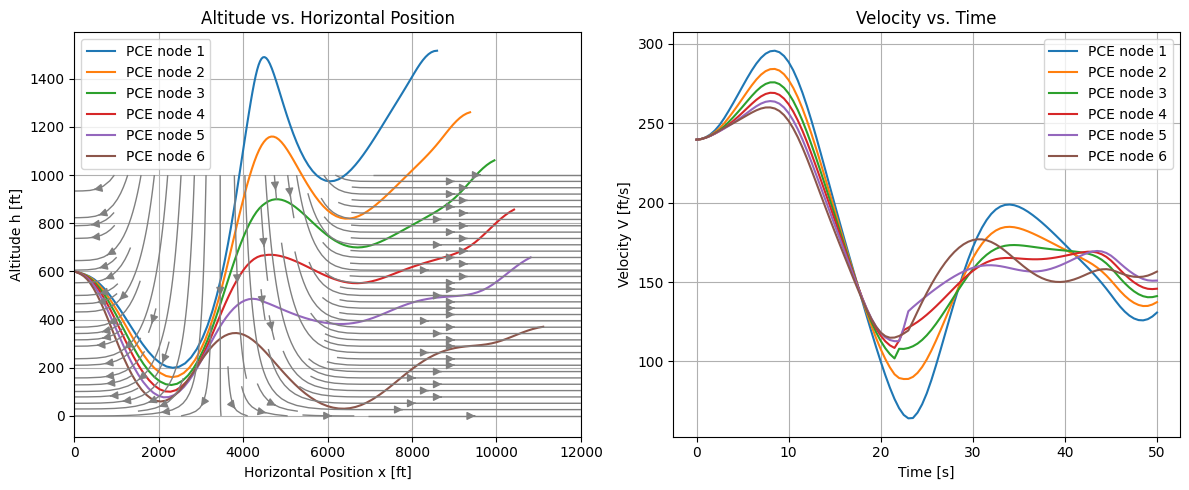

In [72]:
plot_pce_trajectories(res_w_5)

1.8720449355051465
1.848881808335547


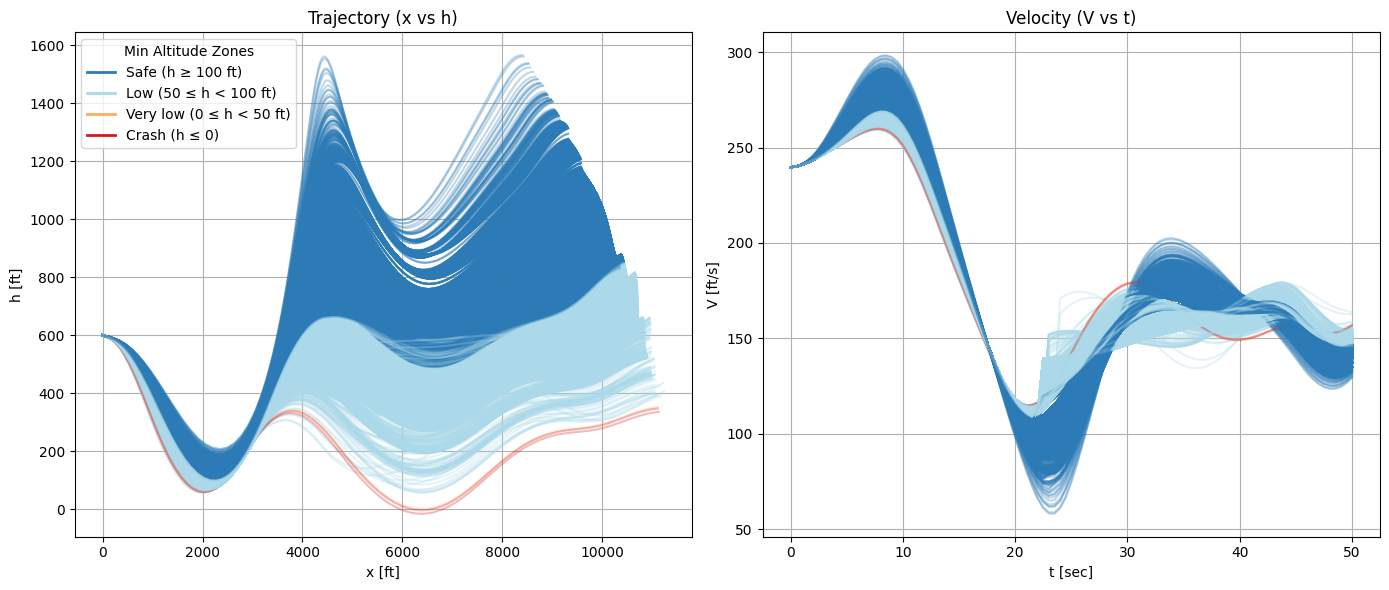

P(Under 100) = 0.2622
P(Under 50) = 0.0003
P(Under 0) = 0.0002


In [73]:
visualize_trajectory(res_w_5["u"])

## Wider Wind 1.2

Wind width scaled by factor 1.2

In [74]:
colors = {
    "safe": "#2c7bb6",      # Dark Blue
    "low": "#abd9e9",       # Light Blue
    "very_low": "#fdae61",  # Orange
    "crash": "#d7191c"      # Red
}

# Physical constants
m = 4662
g = 32.172
delta = 0.03491
A0 = 0.4456e5
A1 = -0.2398e2
A2 = 0.1442e-1
rho = 0.2203e-2
S = 0.1560e4
beta0 = 0.4
beta_dot0 = 0.2
sigma = 3
B0 = 0.1552
B1 = 0.12369
B2 = 2.4203
C0 = 0.7125
C1 = 6.0877
C2 = -9.0277
alpha_star = 0.20944
a = 6e-8
b = -4e-11
c = -np.log(25/30.6)*1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
eps = 1e-6

wx1 = 500
wx2 = 4100 * 1.2
wx3 = 4600 * 1.2

wh1 = 500
wh2 = 4100 * 1.2
wh3 = 4600 * 1.2

# Wind model functions
def Smooth(x_, x0, x1):
    t = (x_ - x0) / (x1 - x0 + eps)
    return ca.if_else(x_ < x0, 0,
           ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

def A_piecewise(x_):
    A1v = -50 + a * x_**3 + b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - a * (wx3 - x_)**3 - b * (wx3 - x_)**4
    A4 = 50
    s1 = Smooth(x_, wx1-30, wx2+30)
    s2 = Smooth(x_, wx2-30, wx2+30)
    s3 = Smooth(x_, wx3-30, wx3+30)
    B12 = (1 - s1)*A1v + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4
    # return ca.if_else(x_ <= wx1, B12,
    #        ca.if_else(x_ <= wx2, B23,
    #        ca.if_else(x_ <= wx3, B34, A4)))
    return ca.if_else(x_ <= wx1, B12,
           ca.if_else(x_ <= wx2, B23, A4))

def B_piecewise(x_):
    B1v = d * x_**3 + e * x_**4
    B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
    B3 = d * (wh3 - x_)**3 + e * (wh3 - x_)**4
    B4 = 0
    s1 = Smooth(x_, wh1-30, wh1+30)
    s2 = Smooth(x_, wh2-30, wh2+30)
    s3 = Smooth(x_, wh3-30, wh3+30)
    B12 = (1 - s1)*B1v + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4
    # return ca.if_else(x_ <= wh1, B12,
    #        ca.if_else(x_ <= wh2, B23,
    #        ca.if_else(x_ <= wh3, B34, B4)))
    return ca.if_else(x_ <= wh1, B12,
           ca.if_else(x_ <= wh2, B23, B4))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = ca.fmax(h_, 10.0)
    return k_ * h_safe / h_star * B_piecewise(x_)

def originalWindModel(x_, h_, k_):
    return wind_x(x_, k_), wind_h(x_, h_, k_)

def C_L(alpha_):
    return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                      C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
def beta(t_):
    return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

def aircraft_ode(k_value):
    x_ = ca.MX.sym('x')
    h_ = ca.MX.sym('h')
    V_ = ca.MX.sym('V')
    gamma_ = ca.MX.sym('gamma')
    alpha_ = ca.MX.sym('alpha')

    u_ = ca.MX.sym('u')
    t_ = ca.MX.sym('t')

    T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
    D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
    L = 0.5 * rho * S * C_L(alpha_) * V_**2

    Wx, Wh = originalWindModel(x_, h_, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_], [ca.gradient(Wx, x_)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_, h_], [ca.gradient(Wh, x_)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_, h_], [ca.gradient(Wh, h_)])

    V_safe = ca.fmax(V_, 1e-3)

    x_dot = V_ * ca.cos(gamma_) + Wx
    h_dot = V_ * ca.sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = (
        T / m * ca.cos(alpha_ + delta)
        - D / m
        - g * ca.sin(gamma_)
        - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
    )
    gamma_dot = (
        T / (m * V_safe) * ca.sin(alpha_ + delta)
        + L / (m * V_safe)
        - g / V_safe * ca.cos(gamma_)
        + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
    )
    alpha_dot = u_

    y0 = ca.vertcat(x_, h_, V_, gamma_, alpha_)
    yk = ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)
    return ca.Function('f', [y0, u_, t_], [yk])

def rk4_step(f, xk, uk, tk, dt):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def reconstruct_trajectory(u_opt, k, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=50, N=100):
    dt = tf / N
    traj = {"x": [], "h": [], "V": [], "gamma": [], "alpha": [], "t": []}
    X = np.array([x0, h0, V0, gamma0, alpha0])

    f = aircraft_ode(k)

    for i, u in enumerate(u_opt):
        t = i * dt
        traj["x"].append(float(X[0]))
        traj["h"].append(float(X[1]))
        traj["V"].append(float(X[2]))
        traj["gamma"].append(float(X[3]))
        traj["alpha"].append(float(X[4]))
        traj["t"].append(t)
        X = rk4_step(f, X, u, t, dt)

    traj["x"].append(float(X[0]))
    traj["h"].append(float(X[1]))
    traj["V"].append(float(X[2]))
    traj["gamma"].append(float(X[3]))
    traj["alpha"].append(float(X[4]))
    traj["t"].append(t + dt)
    return traj

def visualize_trajectory(u_opt, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=50, N=100):
    k_values = np.random.normal(1.0, 0.25, 10000)

    under_0, under_50, under_100 = 0, 0, 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for k in k_values:
        traj = reconstruct_trajectory(u_opt, k)

        if min(traj["h"]) < 1e-6:
            under_0 += 1
            print(k)
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["crash"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["crash"])
        elif min(traj["h"]) < 50:
            under_50 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["very_low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["very_low"])
        elif min(traj["h"]) < 100:
            under_100 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["low"])
        else:
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["safe"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["safe"])

    ax1.set_xlabel("x [ft]")
    ax1.set_ylabel("h [ft]")
    ax1.set_title("Trajectory (x vs h)")
    ax1.grid(True)
    legend_elements = [
        Line2D([0], [0], color=colors["safe"],      lw=2, label='Safe (h ≥ 100 ft)'),
        Line2D([0], [0], color=colors["low"],       lw=2, label='Low (50 ≤ h < 100 ft)'),
        Line2D([0], [0], color=colors["very_low"],  lw=2, label='Very low (0 ≤ h < 50 ft)'),
        Line2D([0], [0], color=colors["crash"],     lw=2, label='Crash (h ≤ 0)')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', title="Min Altitude Zones")

    ax2.set_xlabel("t [sec]")
    # ax2.set_xlabel("x [ft]")
    ax2.set_ylabel("V [ft/s]")
    ax2.set_title("Velocity (V vs t)")
    ax2.grid(True)
    # ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"P(Under 100) = {(under_100+under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 50) = {(under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 0) = {under_0/len(k_values):.4f}")

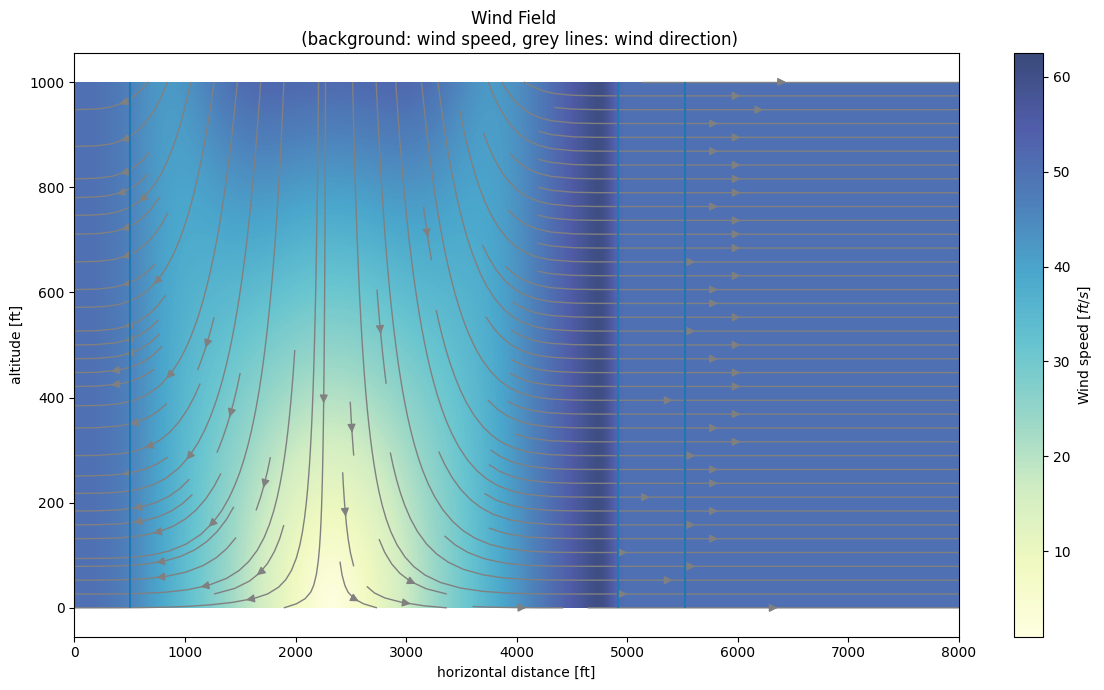

In [75]:
# --------- Wind Field ---------
k_value = 1   # wind intensity factor
x_range = np.linspace(0, 8000, 61)
h_range = np.linspace(0, 1000, 61)
X, H = np.meshgrid(x_range, h_range)

Wx = wind_x(X, k_value)
Wh = wind_h(X, H, k_value)
wind_strength = np.sqrt(Wx**2 + Wh**2)

# --------- Background ---------
plt.figure(figsize=(12, 7))
im = plt.imshow(wind_strength, extent=(x_range[0], x_range[-1], h_range[0], h_range[-1]),
                origin='lower', aspect='auto', cmap='YlGnBu', interpolation='bicubic', alpha=0.8)

plt.colorbar(im, label='Wind speed $[ft/s]$')

# --------- Wind Direction Streamlines ---------
plt.streamplot(x_range, h_range, Wx, Wh, color='grey', linewidth=1, density=1.3, arrowsize=1.2, arrowstyle='-|>')

plt.vlines(wx1, 0, 1000)
plt.vlines(wx2, 0, 1000)
plt.vlines(wx3, 0, 1000)


plt.xlabel('horizontal distance [ft]')
plt.ylabel('altitude [ft]')
plt.title(f'Wind Field \n (background: wind speed, grey lines: wind direction)')
# plt.legend()
plt.tight_layout()
plt.show()

In [76]:
def plot_pce_trajectories(res, tf=50, N=100):
    x = res['x']    # shape: (M, N+1)
    h = res['h']
    V = res['V']
    M = x.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    print(min(h.flatten()))

    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(1,2,1)
    for j in range(M):
        plt.plot(x[j], h[j], label=f'PCE node {j+1}')
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()
    x_range = np.linspace(0, 12000, 61)
    h_range = np.linspace(0, 1000, 61)
    plt.streamplot(x_range, h_range, Wx, Wh, color='grey', linewidth=1, density=1.3, arrowsize=1.2, arrowstyle='-|>')

    # V-t plot
    plt.subplot(1,2,2)
    for j in range(M):
        plt.plot(t_grid, V[j], label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [77]:
def solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25):
    # Time and discretization
    tf = 50        # final time [sec]
    N = 100        # number of control intervals
    dt = tf / N    # time step

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    nodes = nodes.flatten()
    M = len(nodes)    # M = pce_order + 1

    Psi_mat = np.zeros((M, M))
    for i in range(M):
        Psi_mat[:, i] = poly_basis[i](nodes)

    Psi_dm = ca.DM(Psi_mat)
    weights_dm = ca.DM(weights).T

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    X_pce = opti.variable(5*(pce_order+1), N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    k_sym = ca.MX.sym("k")
    Wx_expr = wind_x(x_sym, k_sym)
    Wh_expr = wind_h(x_sym, h_sym, k_sym)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_, k_val):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2

        Wx = wind_x(x_, k_val)
        Wh = wind_h(x_, h_, k_val)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_, k_val)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_, k_val)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_, k_val)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt, k_val):
        k1 = f(xk, uk, tk, k_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    J = 0

    # Initial conditions
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
    opti.subject_to(gamma_s[:, -1] >= 0)

    for j, k_val in enumerate(nodes):

        for i in range(N):
            h_physical = h_s[:, i] * hscale
            h_mean = ca.mtimes(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(weights_dm * h_physical.T, Psi_dm)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            tk = i * dt     # New line
            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.mtimes(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

        opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
        opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)


    # # Cost function
    # J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opts = {
        "expand": True,
        "ipopt": {
            # "max_iter": 3000,
            "max_cpu_time": 120,
            "tol": 1e-6,
            "print_level": 0,
            "linear_solver": "mumps",
            "hessian_approximation": "limited-memory",
            # "bound_push": 1e-8,
            # "bound_frac": 1e-8
        }
    }
    opti.solver("ipopt", opts)

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        print(e)
        return {
            "x": opti.debug.value(x),
            "h": opti.debug.value(h),
            "V": opti.debug.value(V),
            "gamma": opti.debug.value(gamma),
            "alpha": opti.debug.value(alpha),
            "u": opti.debug.value(u),
            "J": opti.debug.value(J),
            "status": "failed"
        }

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
        "status": "success"
    }

### Order 1

In [78]:
res_w1_1 = solve_ocp_pce(pce_order=1)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  74.90ms ( 10.53us)  74.75ms ( 10.51us)      7114
       nlp_g  |   7.88 s (  1.11ms)   7.89 s (  1.11ms)      7114
  nlp_grad_f  |  52.70ms ( 19.31us)  52.16ms ( 19.11us)      2730
   nlp_jac_g  |  18.55 s (  6.73ms)  18.56 s (  6.74ms)      2756
       total  |  52.48 s ( 52.48 s)  52.50 s ( 52.50 s)         1


135.96322107332992


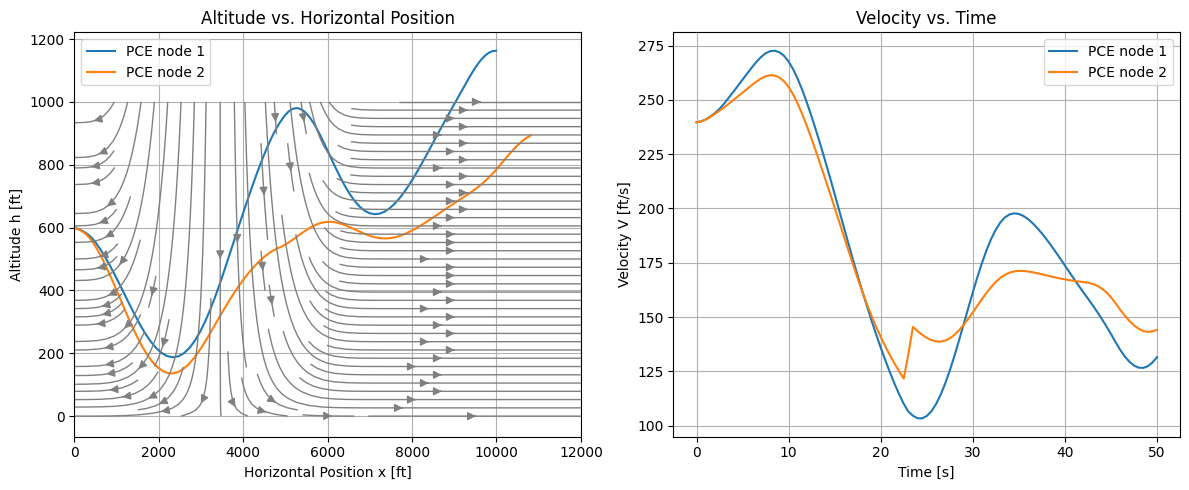

In [79]:
plot_pce_trajectories(res_w1_1)

1.7969709889282335
1.7675470847211807
1.7580853771549596
1.758594869870155
1.7730757018023835
1.797311379127316
1.875406427492828
1.7715488821135699
1.8000251569350958
1.9670924051848568
1.8065053294317963


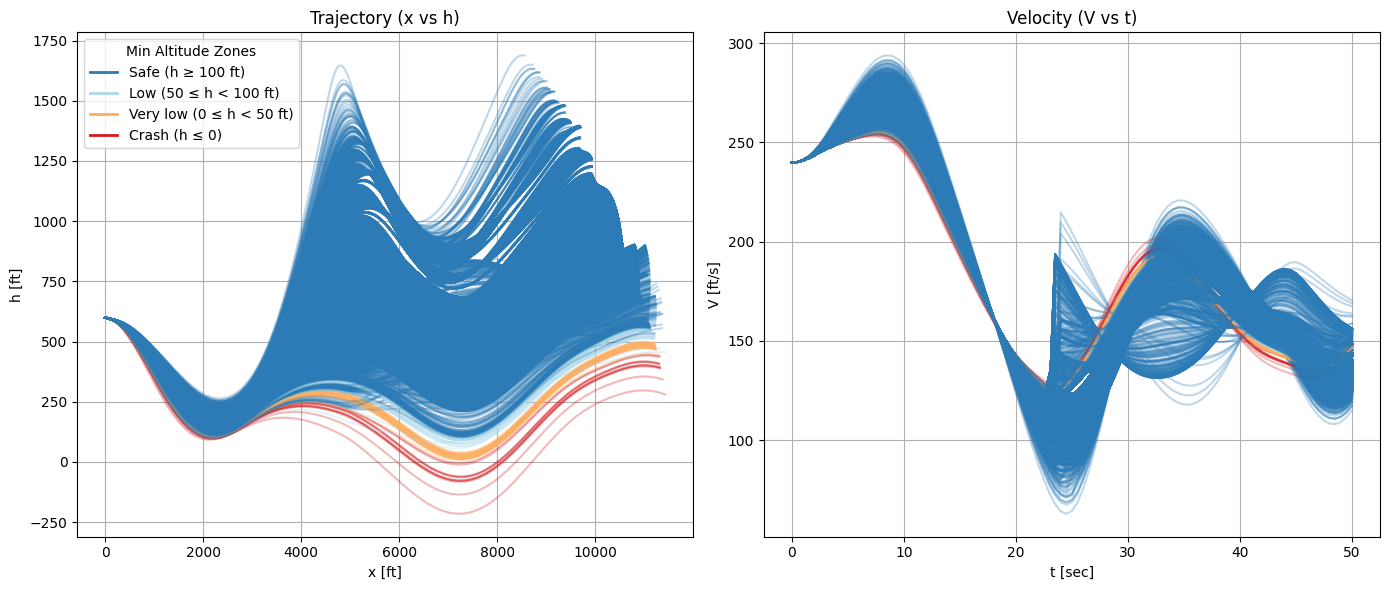

P(Under 100) = 0.0071
P(Under 50) = 0.0039
P(Under 0) = 0.0011


In [80]:
visualize_trajectory(res_w1_1["u"])

### Order 2

In [81]:
res_w1_2 = solve_ocp_pce(pce_order=2)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.89ms ( 33.13us)  11.91ms ( 33.19us)       359
       nlp_g  | 593.17ms (  1.65ms) 593.91ms (  1.65ms)       359
  nlp_grad_f  |  13.04ms ( 51.33us)  12.94ms ( 50.93us)       254
   nlp_jac_g  |   2.57 s ( 10.12ms)   2.57 s ( 10.13ms)       254
       total  |   7.07 s (  7.07 s)   7.08 s (  7.08 s)         1


132.11615883972416


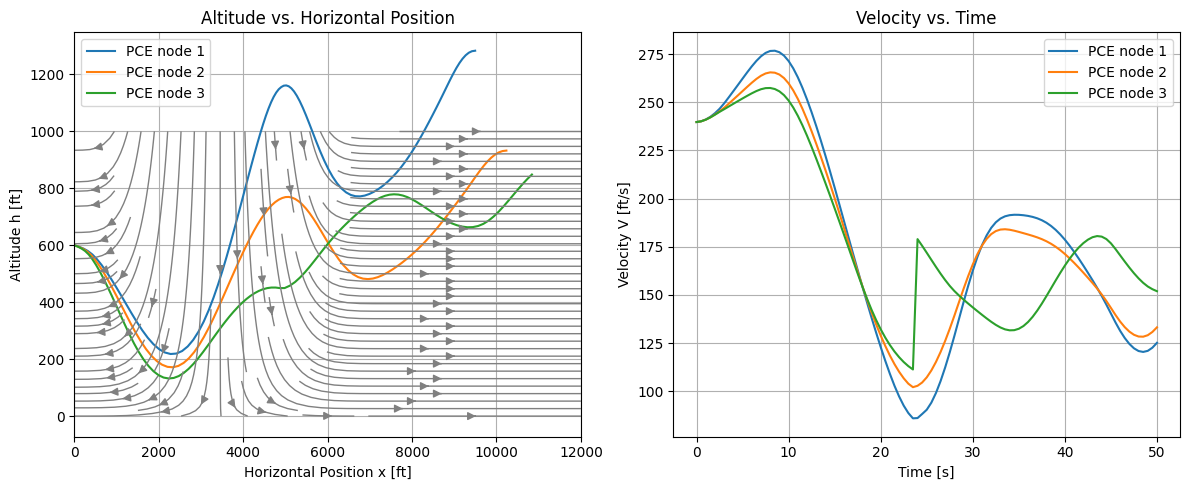

In [82]:
plot_pce_trajectories(res_w1_2)

1.775764618993465
1.9004812451759718
1.8743263657928537
1.7930825441342253
1.8515506734568028
1.8555037284397566
1.7928491504786148


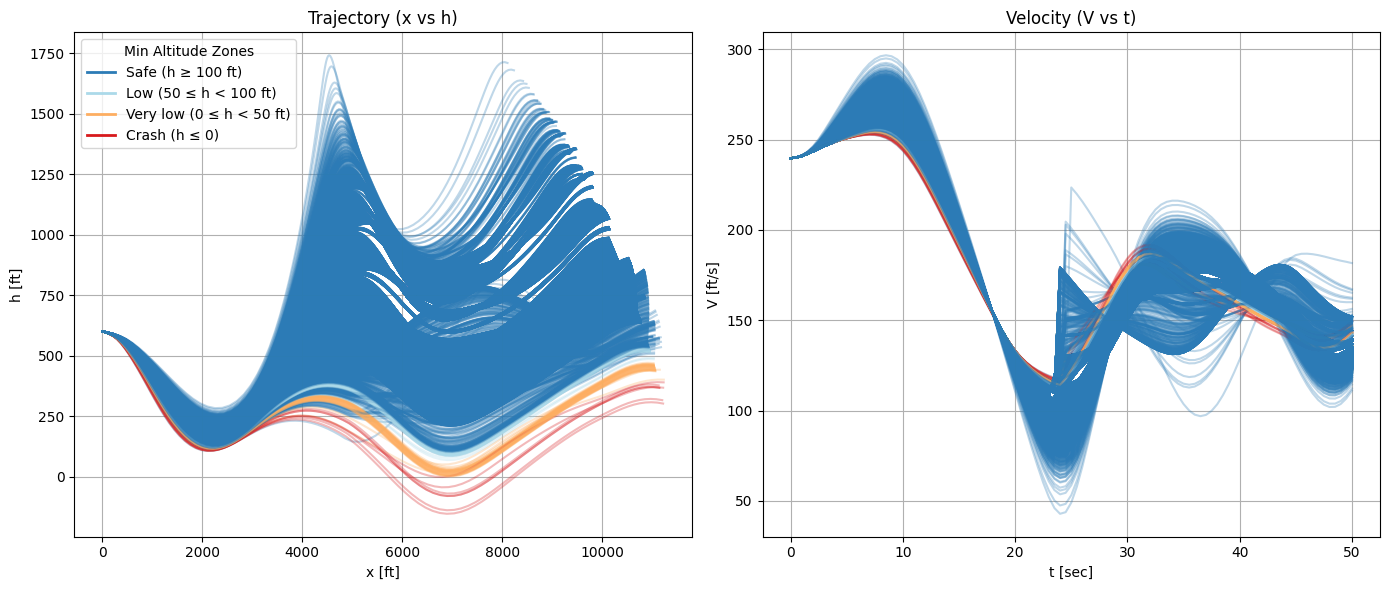

P(Under 100) = 0.0074
P(Under 50) = 0.0038
P(Under 0) = 0.0007


In [83]:
visualize_trajectory(res_w1_2["u"])

### Order 3

In [84]:
res_w1_3 = solve_ocp_pce(pce_order=3)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  29.97ms ( 44.53us)  29.96ms ( 44.52us)       673
       nlp_g  |   1.50 s (  2.22ms)   1.50 s (  2.23ms)       673
  nlp_grad_f  |  23.21ms ( 84.73us)  23.22ms ( 84.75us)       274
   nlp_jac_g  |   3.95 s ( 13.67ms)   3.97 s ( 13.72ms)       289
       total  |  11.05 s ( 11.05 s)  11.18 s ( 11.18 s)         1


114.60781500401798


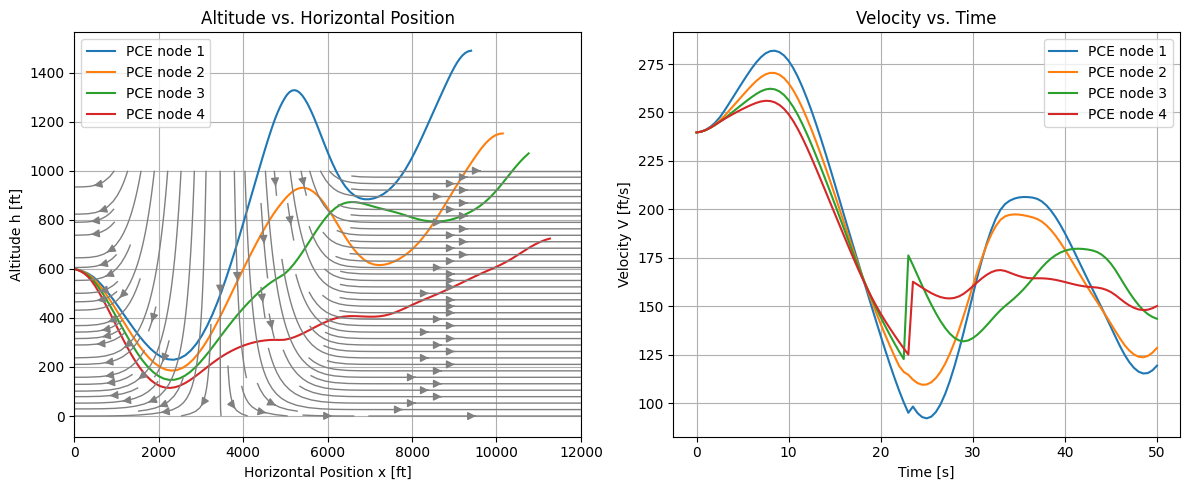

In [85]:
plot_pce_trajectories(res_w1_3)

1.730578509968745
1.7261387285698682
1.825303493148218
1.764002187130798
1.7648072386032911
1.735196812584579
1.7210853144179978
1.733136912520207
1.8761637947185354
1.7642083033247185
1.734816245805972
1.8467609671767575
1.7559785439819398
1.736958441843542
1.7284880699543366


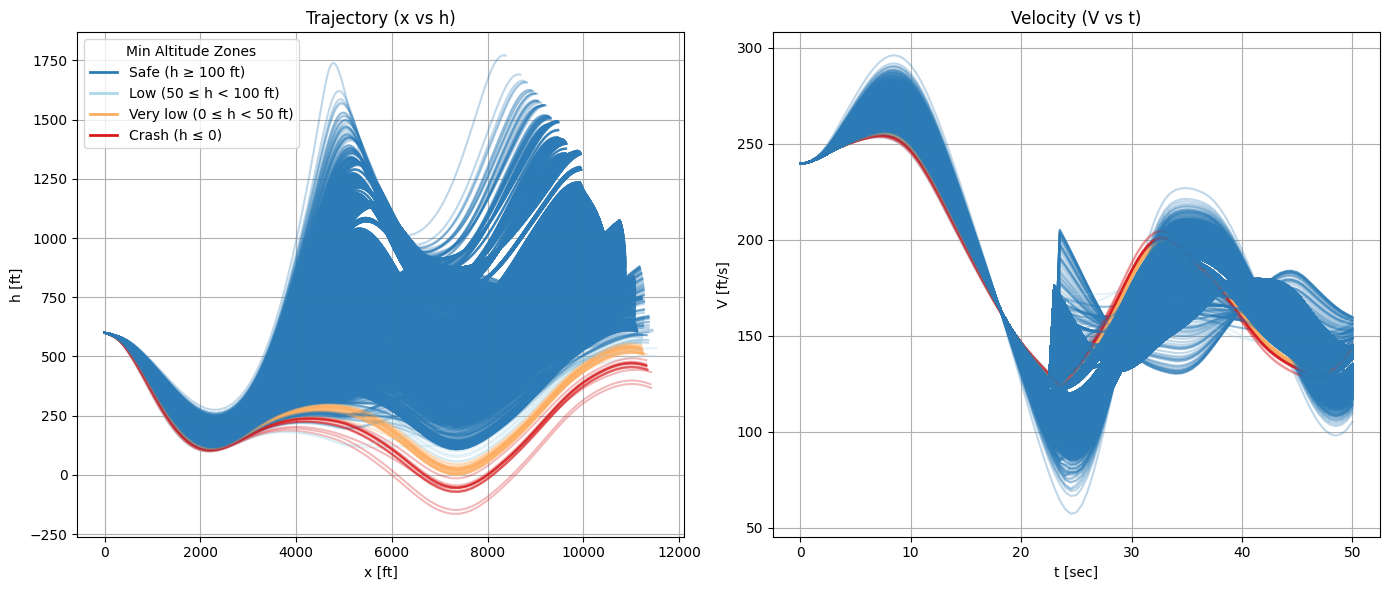

P(Under 100) = 0.0051
P(Under 50) = 0.0044
P(Under 0) = 0.0015


In [86]:
visualize_trajectory(res_w1_3["u"])